In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 15.7MB/s 
     |████████████████████████████████| 870kB 52.5MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=bc9ccc50a58ba7773aed7fe237264ad456b139d19bd87316cf44e6d9e9cce785
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [4]:
import os, sys

print('Importing dataset...')

from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/ARK Task")

Importing dataset...
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./train.txt", delimiter='\n', header=None, encoding='ISO-8859-1')

In [ ]:
label1 = []
label0 = []
# 0=unacceptable, 1=acceptable
for i in range(len(df)):
  item = df[0][i].split('\t')
  label1.append(item[0])
  label0.append(item[1])

In [ ]:
new_label1 = []
for i in range(len(label1)):
  new_label1.append([label1[i], '1'])

In [ ]:
new_label0 = []
for i in range(len(label0)):
  new_label0.append([label0[i], '0'])

In [ ]:
new_label1[0]

['En route , they pick up a seemingly-harmless hitchhiker , and continue their journey , only for their car to break down in a deserted motel on a lonely highway .',
 '1']

In [ ]:
import pandas as pd
df1 = pd.read_csv("label1.csv", delimiter=',', header=None, names=['sentence', 'label'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df1.shape[0]))

Number of training sentences: 998,702



In [ ]:
df1 = df1[1:]

In [ ]:
df1.head()

,sentence,label
1,"En route , they pick up a seemingly-harmless h...",1
2,"Jobs, however, are not created by supporting a...",1
3,"Due to circumstances , he is forced to abandon...",1
4,I should just like to highlight two issues.,1
5,Jerry is finally released from hospital and re...,1


In [ ]:
df2 = pd.read_csv("label0.csv", delimiter=',', header=None, names=['sentence', 'label'])
df2 = df2[1:]
df2.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sentence,label
1,"En route , they pick up a seemingly-harmless h...",0
2,"Jobs, however, are not created by supporting a...",0
3,"Due to circumstances , he is forced to abandon...",0
4,I should just like to hihglight two issues.,0
5,Jerry is finally released from hospital and re...,0


In [ ]:
df = df1.append(df2)

In [ ]:
df.to_csv('corpus.csv', index=False)

In [ ]:
df["label"] = df["label"].astype(str).astype(int)

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  En route , they pick up a seemingly-harmless hitchhiker , and continue their journey , only for their car to break down in a deserted motel on a lonely highway .
Tokenized:  ['en', 'route', ',', 'they', 'pick', 'up', 'a', 'seemingly', '-', 'harmless', 'hitch', '##hi', '##ker', ',', 'and', 'continue', 'their', 'journey', ',', 'only', 'for', 'their', 'car', 'to', 'break', 'down', 'in', 'a', 'deserted', 'motel', 'on', 'a', 'lonely', 'highway', '.']
Token IDs:  [4372, 2799, 1010, 2027, 4060, 2039, 1037, 9428, 1011, 19741, 27738, 4048, 5484, 1010, 1998, 3613, 2037, 4990, 1010, 2069, 2005, 2037, 2482, 2000, 3338, 2091, 1999, 1037, 12768, 14901, 2006, 1037, 9479, 3307, 1012]


In [ ]:
len(sentences)

1997402

## Training

In [ ]:
input_ids = []
attention_masks = []

# For every sentence
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  En route , they pick up a seemingly-harmless hitchhiker , and continue their journey , only for their car to break down in a deserted motel on a lonely highway .
Token IDs: tensor([  101,  4372,  2799,  1010,  2027,  4060,  2039,  1037,  9428,  1011,
        19741, 27738,  4048,  5484,  1010,  1998,  3613,  2037,  4990,  1010,
         2069,  2005,  2037,  2482,  2000,  3338,  2091,  1999,  1037, 12768,
        14901,  2006,  1037,  9479,  3307,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)


train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,797,661 training samples
199,741 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12-layer BERT model, with an uncased vocab.
    num_labels = 2, 
                    
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_mask = b_input_mask.type(torch.LongTensor)
        b_labels = b_labels.type(torch.LongTensor)

        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    attention_masks
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Streaming output truncated to the last 5000 lines.
  Batch 26,440  of  56,177.    Elapsed: 0:56:37.
  Batch 26,480  of  56,177.    Elapsed: 0:56:42.
  Batch 26,520  of  56,177.    Elapsed: 0:56:47.
  Batch 26,560  of  56,177.    Elapsed: 0:56:52.
  Batch 26,600  of  56,177.    Elapsed: 0:56:58.
  Batch 26,640  of  56,177.    Elapsed: 0:57:03.
  Batch 26,680  of  56,177.    Elapsed: 0:57:08.
  Batch 26,720  of  56,177.    Elapsed: 0:57:13.
  Batch 26,760  of  56,177.    Elapsed: 0:57:18.
  Batch 26,800  of  56,177.    Elapsed: 0:57:23.
  Batch 26,840  of  56,177.    Elapsed: 0:57:28.
  Batch 26,880  of  56,177.    Elapsed: 0:57:33.
  Batch 26,920  of  56,177.    Elapsed: 0:57:38.
  Batch 26,960  of  56,177.    Elapsed: 0:57:44.
  Batch 27,000  of  56,177.    Elapsed: 0:57:49.
  Batch 27,040  of  56,177.    Elapsed: 0:57:54.
  Batch 27,080  of  56,177.    Elapsed: 0:57:59.
  Batch 27,120  of  56,177.    Elapsed: 0:58:04.
  Batch 27,160  of  56,177.    Elapsed: 0:58:09.
  Batch 27,200  of

In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.37,0.34,0.86,2:00:02,0:03:43
2,0.29,0.35,0.86,1:59:55,0:03:43
3,0.24,0.39,0.86,1:59:28,0:03:42
4,0.20,0.43,0.86,1:58:37,0:03:43


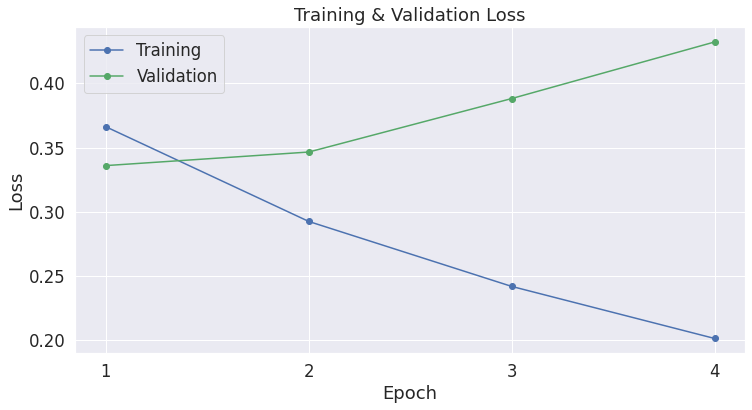

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import os

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
from transformers import BertForSequenceClassification

output_dir = './saved_model/BERT_model'

print(output_dir)

./saved_model/BERT_model


## Test

In [ ]:
df_test = pd.read_csv("./test.rand.txt", delimiter='\n', header=None, encoding='ISO-8859-1')
df_test.head()

In [ ]:
len(df_test)

In [ ]:
label_lst = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model.to(device)

for i in range(len(df_test)):
  item = df_test[0][i].split('\t')
  sent1 = item[0]
  sent2 = item[1]

  encoded_dict1 = tokenizer.encode_plus(
                        sent1,                      
                        add_special_tokens = True, 
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )   
  input_id1 = encoded_dict1['input_ids']   
  attention_mask1 = encoded_dict1['attention_mask']
  input_id1 = torch.LongTensor(input_id1)
  attention_mask1 = torch.LongTensor(attention_mask1)

  encoded_dict2 = tokenizer.encode_plus(
                        sent2,                      
                        add_special_tokens = True, 
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
  input_id2 = encoded_dict2['input_ids']   
  attention_mask2 = encoded_dict2['attention_mask']
  input_id2 = torch.LongTensor(input_id2)
  attention_mask2 = torch.LongTensor(attention_mask2)

  input_id1 = input_id1.to(device)
  attention_mask1 = attention_mask1.to(device)

  input_id2 = input_id2.to(device)
  attention_mask2 = attention_mask2.to(device)

  with torch.no_grad():
    outputs1 = model_loaded(input_id1, token_type_ids=None, attention_mask=attention_mask1)
  with torch.no_grad():
    outputs2 = model_loaded(input_id2, token_type_ids=None, attention_mask=attention_mask2)

  logits1 = outputs1[0]
  logits2 = outputs2[0]
  logits = logits1 / logits2
  index = logits.argmax()
  label_lst.append(index)
  if (i % 1000 == 0):
    print(f'{i} ==> {index}')

In [ ]:
result_lst = []
for i in range(len(label_lst)):
  if label_lst[i] == 1:
    result_lst.append('A')
  else:
    result_lst.append('B')

In [ ]:
with open("./part1_version2.txt", "w") as text_file:
    text_file.write("\n".join(result_lst))